# Imports

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from details import *
from DGM_net import *
from tqdm.notebook import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Setup

In [18]:
torch.manual_seed(15)
torch.set_default_dtype(torch.float32)

In [19]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)

cpu


In [20]:
n_dims = 20
my_dist = torch.distributions.MultivariateNormal(torch.zeros(n_dims),
                                              torch.eye(n_dims))

In [ ]:
"""
cube_coords = []
for i in range(n_dims):
    cube_coords.append([-4., 4.])
cube_coords = torch.tensor(cube_coords)
N = []
for i in range(n_dims):
    N.append(64)
N = torch.tensor(N)
cube_coords_border = torch.tensor([[-4., 4.], [-4., 4.]])
"""

In [21]:
"""
area_sampler = MeshGrid(cube_coords, N)
border_sampler = SquareBorder(cube_coords_border, N)
""";

In [22]:
u = DGM_Net(n_dims, hidden_size = 50, L = 3, activation = torch.tanh).to(device)#u = U_func(n_dims)

area_sampler = my_dist

In [23]:
def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight.data)
        #xavier(m.bias.data)

u.apply(weights_init);

In [24]:
def value_function(x):
    #x = [n_items, n_dims]
    #return x.sum(dim=1)
    #return x[:, 1]
    #return x[:, 1]**3
    #return torch.sin(x).sum(dim=1)
    #return (x**2).sum(dim=1)
    return (x**3).sum(dim=1)
    #return (torch.sin(x**3)).sum(dim=1)

In [25]:
def regular_expectancy(f, p, test_amnt, sample_amnt):
    results = list()
    for i in tqdm(range(test_amnt)):
        samples = p.sample([sample_amnt])
        mean = f(samples).mean()
        results.append(mean.item())
    return results

In [26]:
def spec_exp(f, test_amnt, sample_amnt, p):
    results = list()
    for i in tqdm(range(test_amnt)):
        samples = p.sample([sample_amnt])
        samples.requires_grad=True
        cv = LPDE(u, p.log_prob, samples, diff_gradient, diff_laplacian, cr_gr = False)
        mean = (f(samples) - cv).mean()
        results.append(mean.item())
    return results

In [27]:
def box_comp(a, b):                                                    
    data = [a, b]                                             
    plt.figure(figsize=(12,8))                 
    plt.boxplot(data, showfliers = False, labels =                              
                ["MC Vanila", "Diff CV"])
    plt.grid()
    #plt.show()
    plt.savefig('varianceextrap.eps', format='eps')

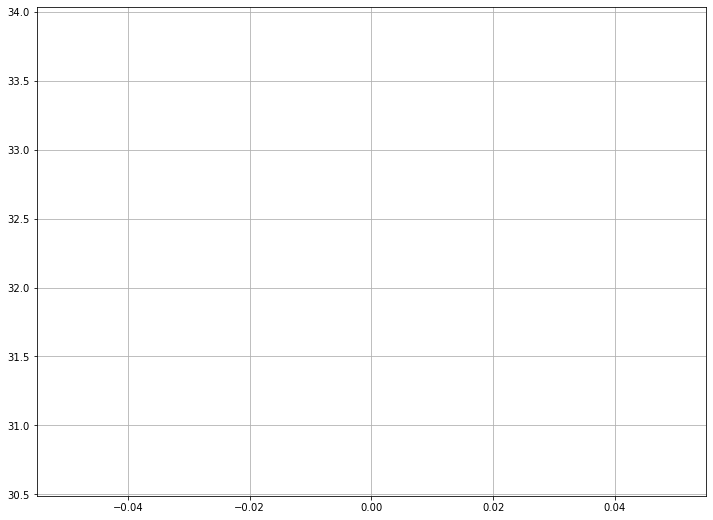

  2%|▏         | 1/50 [03:32<2:53:53, 212.92s/it]


KeyboardInterrupt: 

In [28]:
training(u, value_function, my_dist, area_sampler, border_sampler = None,
             batch_sz = 10**4, lr = 1e-3, verbose = 3, it_num = 50, epochs_amnt = 1,
         resample_its = False, border_sz = 10**2, str_name = "cubicnorm20dim12", dev = device)

In [ ]:
torch.save(u.state_dict(), 'my_modelextrap')

In [ ]:
t_am = 100
s_am = 10**3
reg_exp = regular_expectancy(value_function, my_dist, t_am, s_am)

cv_exp = spec_exp(value_function, t_am, s_am, my_dist)



In [ ]:
box_comp(reg_exp, cv_exp)